## 模块导入

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc  ###计算roc和auc
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from collections import Counter
%matplotlib inline
warnings.filterwarnings('ignore')
try:
    os.makedirs('pictures') # 创建保存图片的文件夹
    os.makedirs('pictures/data_hist')
    os.makedirs('pictures/data_disper_hist')
    os.makedirs('pictures/fuzzy_hist')
    os.makedirs('pictures\\model_cm')
    os.makedirs('pictures\\model_lc')
    os.makedirs('pictures\\model_roc')
except Exception as err:
    print(err)

## 定义工具类-供解决问题使用

### 数据获取

In [2]:
class GetData:
    def __init__(self):
        self.__train_data = pd.read_excel('./Data.xlsx', sheet_name=0)
        self.__test_data = pd.read_excel('./Data.xlsx', sheet_name=1)
        
    @property 
    def train_data(self):
        self.__train_data.rename(columns = {"是否含有特定成分(1为含有，0为不含)": "label"}, inplace=True)
        return self.__train_data
    
    @property
    def test_data(self):
        return self.__test_data
        
        

### 数据可视化

In [3]:
class Visualization:
    """
    数据可视化类，对原始数据可视化，以作为预处理的参考
    """
    def __init__(self):
        pass
    
    @classmethod
    def show_pairplot(cls, data):
        sns.pairplot(data = data, vars=data.iloc[:, :-1], hue='label', palette='husl')
        plt.savefig('pictures/data_pairplot')
        plt.show()
        return
        
    @classmethod
    def show_hist(cls, data, col_num):
#         %matplotlib notebook
#         %matplotlib inline

        plt.figure(figsize = (12, 6), dpi = 80)
#         plt.hist(data.iloc[: , col_num][df_final['label'] == 1], color='r', alpha = 0.6 )
#         plt.hist(data.iloc[: , col_num][df_final['label'] == 0], color='b', alpha = 0.6 )
        sns.distplot(data.iloc[: , col_num][df_final['label'] == 1], color = 'r', label = '1')
        sns.distplot(data.iloc[: , col_num][df_final['label'] == 0], color = 'b', label = '0')
#         plt.xticks(np.arange(0, 9, 1))
        plt.title(list(data.columns)[col_num])
        plt.legend()
        plt.grid()
        plt.savefig("pictures/data_hist/"+list(data.columns)[col_num])
        plt.show()
        return
    
    @classmethod
    def show_disper_hist(cls, data, col_num, k):
#         %matplotlib notebook
#         %matplotlib inline

        plt.figure(figsize = (14, 8), dpi = 80)
#         plt.hist(data.iloc[: , col_num][df_final['label'] == 1], color='r', alpha = 0.6 )
#         plt.hist(data.iloc[: , col_num][df_final['label'] == 0], color='b', alpha = 0.6 )
        sns.distplot(data.iloc[: , col_num][df_final['label'] == 1], bins = np.arange(0, k, ), color = 'r', label = '1')
        sns.distplot(data.iloc[: , col_num][df_final['label'] == 0], bins = np.arange(0, k, ), color = 'b', label = '0')
        plt.xticks(np.arange(0, k, 1))
        plt.title(list(data.columns)[col_num])
        plt.legend()
        plt.savefig("pictures/data_disper_hist/"+list(data.columns)[col_num])
        plt.grid()
        plt.show()
        return
    
    @classmethod
    def show_fuzzy_hist(cls, col_num, fuzzy_final, df_final):
        plt.figure(figsize = (12, 6), dpi = 80)
    #     plt.hist(df_final.iloc[: , col_num][df_final['label'] == 1], color='r',bins=bins_k, alpha = 0.6, label='1')
    #     plt.hist(df_final.iloc[: , col_num][df_final['label'] == 0], color='b',bins=bins_k, alpha = 0.6, label='0')
    #     plt.hist(df_final.iloc[: , col_num][df_final['label'] == 1], color='r',bins=bins_k, density=True, alpha = 0.6, label='1')
    #     plt.hist(df_final.iloc[: , col_num][df_final['label'] == 0], color='b',bins=bins_k, density=True, alpha = 0.6, label='0')
    #     df_final.iloc[: , col_num][df_final['label'] == 1].plot(kind='kde')
    #     df_final.iloc[: , col_num][df_final['label'] == 0].plot(kind='kde')
        sns.distplot(df_final.iloc[: , col_num][df_final['label'] == 1], color = 'red', label = '1')
        sns.distplot(df_final.iloc[: , col_num][df_final['label'] == 0], color = 'blue', label = '0')
        index=2
        for i in range(len(fuzzy_final[col_num])//2):
            plt.plot(fuzzy_final[col_num][index-2:index], list([.3,.3]), linewidth = 3, color = "black")
            index+=2
        plt.title(list(df_final.columns)[col_num])
        plt.savefig("pictures/fuzzy_hist/"+list(df_final.columns)[col_num])
        plt.legend()
        plt.grid()
        plt.show()
    
    @classmethod
    def show_corr(cls, data):
        
        plt.figure(figsize = (12, 8))
        sns.heatmap(data.corr(), annot=True, cmap=plt.cm.rainbow, linewidths=0.2) #data.corr()-->correlation matrix
        plt.savefig('pictures/data_corr_matrix')
        plt.show()
        return    

### 数据预处理

### 参数择优

In [4]:
class ParamSelect:
    """
    参数寻优类，输入模型及训练集数据，经过网格搜索及交缠验证后，返回最优模型参数
    """
    
    def __init__(self, train_x, train_y, clf = None):
        # 训练集 train_x, train_y
        assert train_x.shape[0] == train_y.shape[0], '特征集和标签长度不一致！'
        self.train_x, self.train_y = train_x, train_y
        # 模型
        self.clf = clf
        
        
    def get_best_param(self, param_grid: list) -> dict:
        """
        :param param_grid: 代调优模型参数列表
        :return: 最优的模型参数best_params_
        """
        # 交叉验证参数择优  
        kfold_gs = StratifiedKFold(n_splits=10, random_state=0)
        # 网格搜索
        grid_search = GridSearchCV(estimator=self.clf,
                param_grid=param_grid,
                scoring='f1_weighted',
                cv=kfold_gs)
#         scores = cross_val_score(grid_search,self.train_x, self.train_y,scoring='accuracy',cv=kfold_cv)
#         print("CV average Accuracy in Train Phase: %.3f +/- %.3f" % (np.mean(scores),np.std(scores)))
        grid_result = grid_search.fit(self.train_x, self.train_y)
        print("参数寻优：\nBest score: %f using %s" % (grid_result.best_score_, grid_search.best_params_))
        return grid_search.best_params_


### 模型评估

In [5]:
class ModelEvaluation:
    """
    模型评估类，对用最佳参数训练的模型，用10折交叉验证，混淆矩阵等方法对模型进行评估，判断模型的优劣。
    """
    
    def __init__(self, clf, test_x, test_y):
        # 模型
        self.clf = clf
        # 总的特征数据
        assert test_x.shape[0] == test_y.shape[0], '特征集和标签长度不一致！'
        self.test_x = test_x
        self.test_y = test_y

    def kfold_cv(self) -> float:
        """
        用在训练集上的最佳参数训练模型后，在测试集（test_x, test_y ： 对模型来说是全新的数据）上进行十折交叉验证，检验模型的好坏
        :param:
        :return: 10折交叉验证后返回f1_score_weighted
        """
        kfold_cv  = StratifiedKFold(n_splits=10, random_state=0)
        # 考虑类别的不平衡性，需要计算类别的加权平均，使用'f1_weighted'而不是f1
        scores = cross_val_score(self.clf, self.test_x, self.test_y, scoring='f1_weighted', cv=kfold_cv)
        print("交叉验证：\n10fold cross validation f1_weighted score in final model: %.3f +/- %.3f" % (np.mean(scores),np.std(scores)))
        return np.mean(scores)
    
    @classmethod   
    def get_f1_score(cls, test_y, pred_y) -> float:
        """
        :param test_y, pred_y: 真实值和预测值
        :return: 根据真实值和预测值计算f1_score
        """
        assert test_y.shape[0] == pred_y.shape[0], '测试集和预测集长度不一致！'
        f1_score_wei = f1_score(test_y, pred_y, average='weighted')      
        return f1_score_wei
    
    @classmethod  
    def show_learning_curve(cls, X, y, clf, title):
        """
        绘制学习曲线：根据训练样本大小的变化，展示分类准确率的改变
        :param clf: 待评估模型
        :return:  
        """
        assert X.shape[0] == y.shape[0]
        print('Learning curve:')
        plt.figure(figsize=(8, 6))
        # 模型
        clf = clf  
        lw = 2
        title = title
        plt.title(title)
        # 设置y轴坐标
        plt.ylim((.3, 1.01))
        plt.xlabel("Training samples")
        plt.ylabel("Score")
        # 获得绘图数据
        cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
        train_sizes, train_scores, test_scores = learning_curve(
            clf, X, y, cv=cv, train_sizes=np.linspace(0.1, 1, 10))
        train_scores_mean = np.mean(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)

        # 画图
        plt.plot(train_sizes, train_scores_mean, 'o-', color="pink", lw=lw,
                 label="Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="lightgreen", lw=lw,
                 label="Cross-validation score")
        plt.grid()
        plt.legend(loc="best")
        plt.savefig('pictures\\model_lc\\' + title)
        plt.show()
        return
    
    @classmethod
    def show_confusion_matrix(cls, test_y, pred_y, model_name: str, classes = ['0','1'],  cmap=plt.cm.rainbow):
        """
         根据真实值和预测值画出混淆矩阵
        :param test_y, pred_y: 真实值和预测值
        :param model_name: 模型名
        :return: 
        """
        title = str(model_name) + '_confusion_matrix'
        plt.rc('font',size='13')   # 设置字体大小
        cm = confusion_matrix(test_y, pred_y)
        print("confusion matrix:\n",cm)
        # 按行进行归一化
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # 占比1%以下的单元格，设为0，防止在最后的颜色中体现出来
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                if int(cm[i, j]*100 + 0.5) == 0:
                    cm[i, j]=0

        fig, ax = plt.subplots(figsize = (7, 5), dpi = 80)
        im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        ax.figure.colorbar(im, ax=ax) # 侧边的颜色条带

        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               xticklabels=classes, yticklabels=classes,
               title=title,
               ylabel='Actual',
               xlabel='Predicted')

        # 通过绘制格网，模拟每个单元格的边框
        ax.set_xticks(np.arange(cm.shape[1]+1)-.5, minor=True)
        ax.set_yticks(np.arange(cm.shape[0]+1)-.5, minor=True)
        ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.2)
        ax.tick_params(which="minor", bottom=False, left=False)

        # 将x轴上的lables旋转45度
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")

        # 标注百分比信息
        fmt = 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                if int(cm[i, j]*100 + 0.5) > 0:
                    ax.text(j, i, format(int(cm[i, j]*100 + 0.5) , fmt) + '%',
                            ha="center", va="center",
                            color="white"  if cm[i, j] > thresh else "black")
        fig.tight_layout()
        plt.savefig('pictures\\model_cm\\' + title)
        plt.show()
        return 
        
    @classmethod
    def show_classification_report(cls, test_y, pred_y):
        """
        根据真实值和预测值打印分类报告
        :param test_y, pred_y: 真实值和预测值
        :return: 
        """
        assert test_y.shape[0] == pred_y.shape[0], '测试集和预测集长度不一致！'
        print("Detailed classification report:")
        print(classification_report(test_y, pred_y))
        return 
        
    @classmethod
    def my_pipeline(cls, train_x, train_y, test_x, test_y, X, y, clf, model_name: str) -> float:
        """
        自定义流水线方法，执行模型评估工作
        :param clf: 分类模型
        :param model_name: 模型名称
        :return:
        """
        # 在测试集（test_x, test_y）全新的数据上做十折交叉验证，评估验证模型
        modelevaluation = ModelEvaluation(clf, test_x, test_y)
        clf.fit(train_x,train_y)
        pred_y = clf.predict(test_x)
        cv_f1_score = modelevaluation.kfold_cv()
        test_f1_score = ModelEvaluation.get_f1_score(test_y, pred_y)
        print('cv-f1-score:', cv_f1_score)
        print('test-f1-score:', test_f1_score)
        ModelEvaluation.show_classification_report(test_y, pred_y)
        ModelEvaluation.show_confusion_matrix(test_y, pred_y, model_name)
        ModelEvaluation.show_learning_curve(X, y, clf,  model_name)
        
        return cv_f1_score
    
    @classmethod
    def show_roc_curve(cls, test_y, y_score, model_name):
        """
        roc 曲线
        """
        
        
        # Compute ROC curve and ROC area for each class
        fpr,tpr,threshold = roc_curve(test_y, y_score) ###计算真正率和假正率
        roc_auc = auc(fpr,tpr) # 计算auc的值 AUC的含义：ROC曲线下的面积（越大越好，1为理想状态）
        plt.figure()
        lw = 3
        plt.figure(figsize=(8,6))
        plt.plot(fpr, tpr, color='r',
                 lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(model_name + '_Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.savefig('pictures\\model_roc\\' + model_name + '_Receiver operating characteristic')
        plt.show()
        return 
    @classmethod
    def get_test_result(cls, clf, test_data, model_name):
        return pd.DataFrame(clf.predict(test_data), columns = [model_name+'_pred_y'])

# 问题分析及解答

In [6]:
def show_model_status(model_name: str):
    """
    打印当前训练模型
    :param model_name: 模型名称
    :return:
    """
    assert isinstance(model_name, str), 'model_name必须为字符串类型！'
    print('-'*100)
    print(model_name, '模型训练及评估：')
    return 
model_list = ['DecisionTree', 'Knn', 'Svm']
# 用来记录每个模型10折交叉验证f1分数的DataFrame
df_score = pd.DataFrame(columns = ['cv_f1_score', 'accuracy'])
# 记录测试数据前10条预测值
df_pred = pd.DataFrame()

### 获取数据

In [7]:
get_data = GetData()
df_final = get_data.train_data
df_test = get_data.test_data

In [8]:
df_final.head()

,V1,V2,V3,V4,V5,V6,V7,label
0,0.535424,0.910960,0.524026,0.992520,0.837432,0.895676,0.632646,1
1,0.431184,0.763346,0.350371,0.885103,0.532782,0.926587,0.621668,1
2,0.857351,0.963743,0.723323,0.997718,0.850043,0.732553,0.437323,1
3,0.013346,0.098378,0.008714,0.781759,0.414321,0.817683,0.410796,0
4,-0.005583,0.056952,-0.016080,0.628570,0.401985,0.704188,0.400392,0


In [9]:
df_final.describe()

,V1,V2,V3,V4,V5,V6,V7,label
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,0.379799,0.581811,0.317147,0.881700,0.590638,0.804141,0.449740,0.694750
std,0.313877,0.331197,0.291529,0.131421,0.210565,0.126345,0.123931,0.460525
min,-0.752723,-0.062687,-1.261943,0.320840,0.134443,0.183343,0.118308,0.000000
25%,0.016551,0.220954,0.013827,0.800967,0.405840,0.721750,0.355693,0.000000
50%,0.468211,0.735289,0.347197,0.943091,0.564188,0.823860,0.434033,1.000000
75%,0.639390,0.868181,0.568549,0.987442,0.783371,0.908167,0.533794,1.000000
max,0.965002,0.985052,0.920936,0.999775,0.994328,0.999482,0.847895,1.000000


### 数据可视化

In [92]:
df_final.isna().sum() 

V1       0
V2       0
V3       0
V4       0
V5       0
V6       0
V7       0
label    0
dtype: int64

#### 箱型图观察异常值

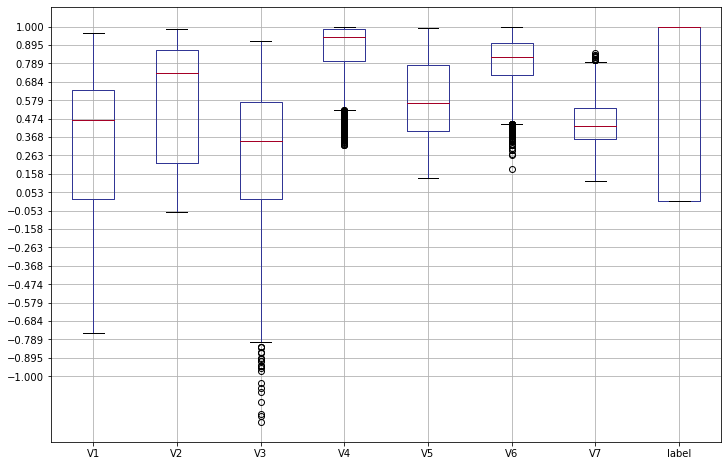

In [10]:
df_final.plot(kind='box', figsize=(12,8), colormap = plt.cm.RdYlBu_r)
plt.yticks(np.linspace(-1,1,20))
plt.grid()
plt.savefig('pictures/data_box')
plt.show()
# 可以看出特征V3、V4、V6、V7都有不同程度数量的离散值，我们先不做处理，在寻找模糊区域时进行判定

#### 数据分布

## 题目一 主要指标判定
* 思路：
- ①根据各个特征和判定标签(是否含有特定成分(1为含有，0为不含)）)的相关性，去判断特征的重要程度，选择出主要指标
- ②用sklearn科学计算库特征选择(feature_selection)库，对主要特征进行选择，验证判断

#### 查看特征相关性

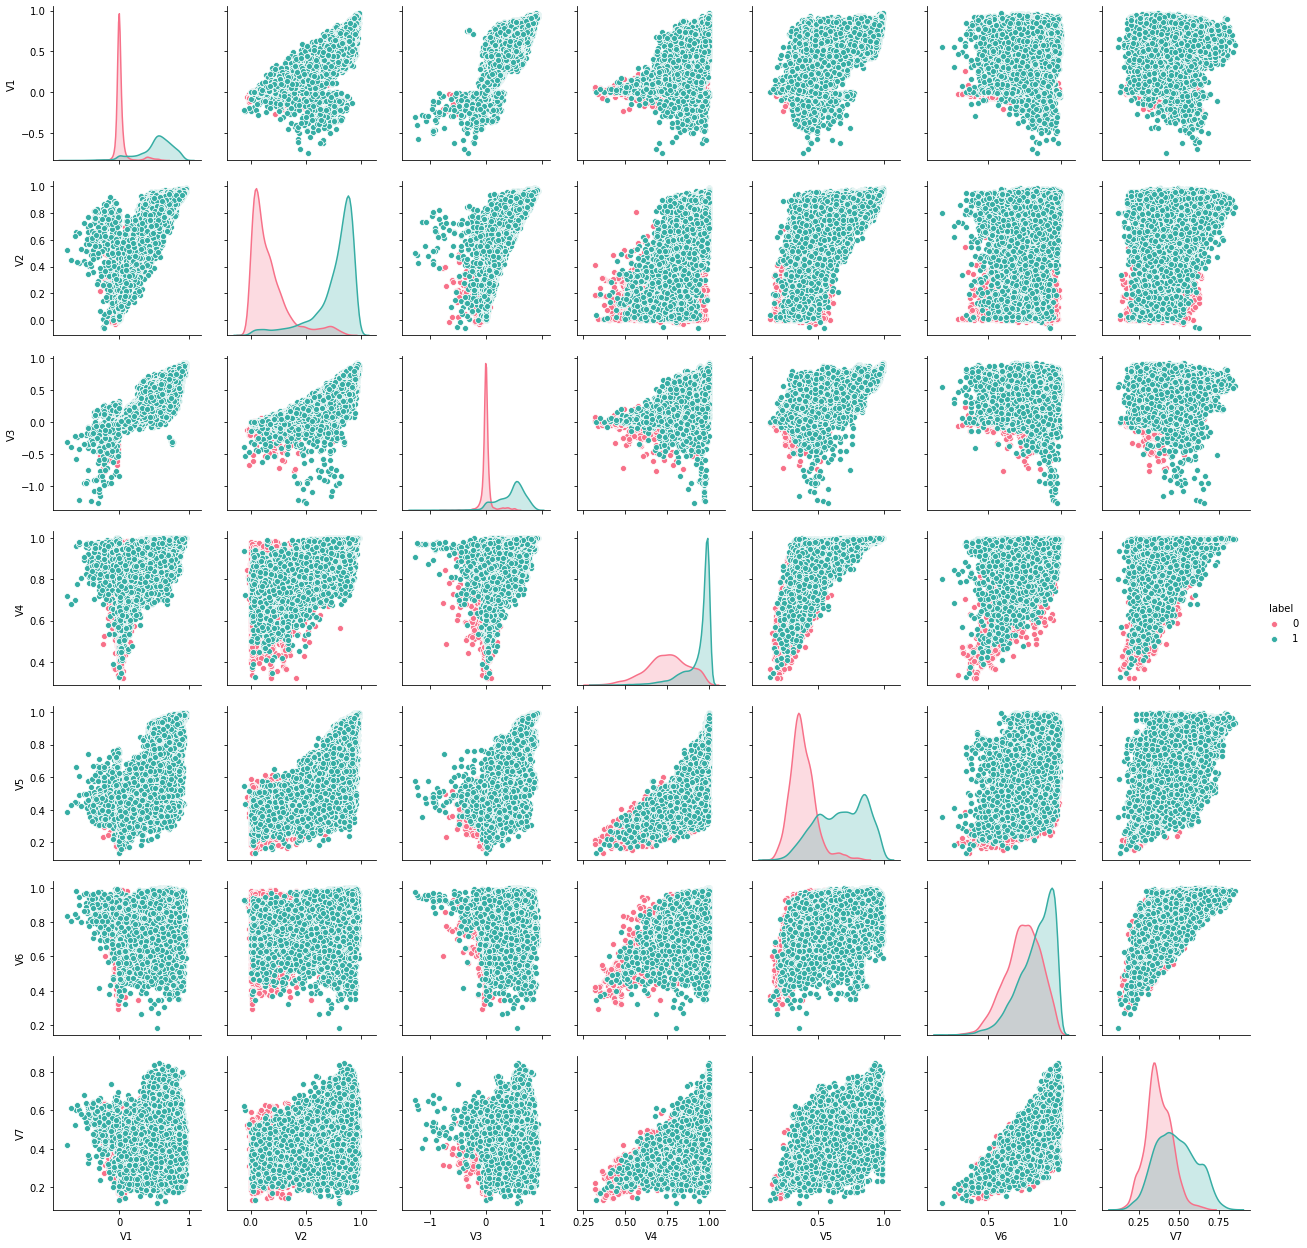

In [11]:
Visualization.show_pairplot(df_final)
# 由于数据较大 此图不能明确看出特征之间的相关关系，但单个特征自身的分布特点可以较清晰的看到。

#### 相关系数矩阵

In [93]:
df_final.corr()

,V1,V2,V3,V4,V5,V6,V7,label
V1,1.000000,0.908051,0.932456,0.738010,0.798685,0.314911,0.376077,0.745024
V2,0.908051,1.000000,0.873408,0.791787,0.801841,0.387905,0.465767,0.819360
V3,0.932456,0.873408,1.000000,0.714739,0.840902,0.306695,0.399386,0.695535
V4,0.738010,0.791787,0.714739,1.000000,0.792374,0.657680,0.600046,0.662179
V5,0.798685,0.801841,0.840902,0.792374,1.000000,0.532812,0.653407,0.644711
V6,0.314911,0.387905,0.306695,0.657680,0.532812,1.000000,0.749076,0.331616
V7,0.376077,0.465767,0.399386,0.600046,0.653407,0.749076,1.000000,0.400044
label,0.745024,0.819360,0.695535,0.662179,0.644711,0.331616,0.400044,1.000000


In [12]:
# 通过相关系数矩阵（各个指标与标签0/1的相关程度），判断出可以判定特定成分存在的主要指标；
# 由相关系数矩阵可以与判定标签（是否含有特定成分(1为含有，0为不含)）相关程度最高的为V1~V5（corr>0.5）
# 即前五个指标对判定特定成分是否存在有重要影响，后面我们将用特征选择的方法进行验证
df_final.corr()[df_final.corr()['label'] > 0.5].index

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'label'], dtype='object')

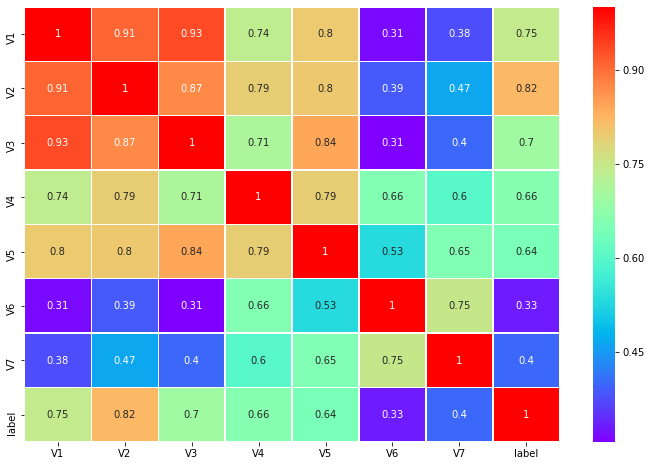

In [13]:
Visualization.show_corr(df_final)

#### 特征选择
- - 特征选择 选择出判断包含特殊成分的主要指标
- 用sklearn的feature_selection库的几种方法，判定特定成分存在的主要指标是否为V1~V5；

In [14]:
# 将总体训练数据，划分为特征集和标签集，进行特征选择
X_test = df_final.iloc[:, :-1]
y_test = df_final.iloc[:, -1:]

**移除低方差特征**
- VarianceThreshold 是特征选择的一个简单基本方法，它会移除所有那些方差不满足一些阈值的特征。默认情况下，它将会移除所有的零方差特征，即那些在所有的样本上的取值均不变的特征。

In [15]:
# 对每一维特征的方差进行计算，并降序排序，可以看出V2的方差最大，V1、V3、V4、V5次之,V6和V7最小，
# 符合相关性矩阵的判断，即前5个特征为主要指标
var = np.var(X_test)
order = np.argsort(var)[::-1]
var[order]

V2    0.109686
V1    0.098514
V3    0.084985
V5    0.044336
V4    0.017271
V6    0.015962
V7    0.015358
dtype: float64

In [16]:
vt = VarianceThreshold(0.017)
vt.fit(X_test)
vt.transform(X_test)

array([[0.53542367, 0.91096035, 0.52402555, 0.99251987, 0.83743224],
       [0.43118433, 0.76334637, 0.35037143, 0.88510284, 0.53278152],
       [0.85735056, 0.96374314, 0.72332305, 0.99771833, 0.8500432 ],
       ...,
       [0.48569784, 0.65250127, 0.34858106, 0.96970543, 0.68989589],
       [0.62170654, 0.89186788, 0.43636619, 0.97583904, 0.57315269],
       [0.45272668, 0.70351594, 0.39736542, 0.73316416, 0.21797554]])

In [17]:
# 由VarianceThreshold方法选择出来的特征与原始数据V1~V5完全相同
vt = VarianceThreshold(0.017)
vt.fit(X_test)
vt.transform(X_test)==np.array(df_final.iloc[:,:5]) 

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       ...,
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]])

**单变量特征选择**
- 单变量的特征选择是通过基于单变量的统计测试来选择最好的特征。它可以当做是评估器的预处理步骤。Scikit-learn 将特征选择的内容作为实现了 transform 方法的对象：
- SelectKBest 移除那些除了评分最高的 K 个特征之外的所有特征

In [18]:
sk = SelectKBest(k = 5)
sk.fit(X_test, y_test)
sk.transform(X_test) 

array([[0.53542367, 0.91096035, 0.52402555, 0.99251987, 0.83743224],
       [0.43118433, 0.76334637, 0.35037143, 0.88510284, 0.53278152],
       [0.85735056, 0.96374314, 0.72332305, 0.99771833, 0.8500432 ],
       ...,
       [0.48569784, 0.65250127, 0.34858106, 0.96970543, 0.68989589],
       [0.62170654, 0.89186788, 0.43636619, 0.97583904, 0.57315269],
       [0.45272668, 0.70351594, 0.39736542, 0.73316416, 0.21797554]])

In [19]:
sk.scores_   # 可以看出前5个特征评分最高

array([24947.50960615, 40851.00161926, 18740.49982261, 15616.15347853,
       14224.74748742,  2470.88995306,  3810.14255173])

In [20]:
# 由SelectKBest方法选择出来的评分最高的5个特征与原始数据V1~V5完全相同
sk.transform(X_test)==np.array(df_final.iloc[:,:5]) 

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       ...,
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]])

**递归式特征消除**
- 给定一个外部的估计器，可以对特征赋予一定的权重（比如，线性模型的相关系数），recursive feature elimination ( RFE ) 通过考虑越来越小的特征集合来递归的选择特征。 首先，评估器在初始的特征集合上面训练并且每一个特征的重要程度是通过一个 coef_ 属性 或者 feature_importances_ 属性来获得。 然后，从当前的特征集合中移除最不重要的特征。在特征集合上不断的重复递归这个步骤，直到最终达到所需要的特征数量为止。

In [21]:
svc = svm.SVC(kernel="linear", C=1)
rfe = RFE(estimator=svc, n_features_to_select=5, step=1)
rfe.fit(X_test, y_test)
rfe.transform(X_test)[:5,:]

array([[ 0.53542367,  0.91096035,  0.52402555,  0.99251987,  0.83743224],
       [ 0.43118433,  0.76334637,  0.35037143,  0.88510284,  0.53278152],
       [ 0.85735056,  0.96374314,  0.72332305,  0.99771833,  0.8500432 ],
       [ 0.01334642,  0.09837763,  0.00871376,  0.78175911,  0.41432096],
       [-0.00558259,  0.05695215, -0.01608028,  0.62856991,  0.40198495]])

In [22]:
# 由RFE方法递归移除最不重要的特征后，选择出来的评分最高的5个特征与原始数据V1~V5完全相同
rfe.transform(X_test)[:,:]==np.array(df_final.iloc[:,:5]) 

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       ...,
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]])

**基于 Tree（树）的特征选取**
- 基于树的 estimators （查阅 sklearn.tree 模块和树的森林 在 sklearn.ensemble 模块） 可以用来计算特征的重要性，然后可以消除不相关的特征（当与 sklearn.feature_selection.SelectFromModel 等元转换器一同使用时）

In [23]:
clf = ExtraTreesClassifier(random_state=60)
clf = clf.fit(X_test, y_test)
important_feature = pd.DataFrame(clf.feature_importances_, index = list('1234567'), columns = ['V'])  

In [24]:
important_feature.sort_values(by='V', ascending = False).T # 特征重要程度最高的仍然是前5个特征，其中V2特征最为重要

,2,1,4,3,5,7,6
V,0.420104,0.166001,0.112284,0.111308,0.108806,0.04196,0.039536


In [25]:
# 由基于树的特征选取方法，选择出来的评分最高的5个特征与原始数据V1~V5完全相同
model = SelectFromModel(clf, prefit=True, threshold=0.1)
model.transform(X_test) == np.array(df_final.iloc[:,:5]) 

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       ...,
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]])

**综上，使用四种feature_selection的方法后，得到的结果都是特征V1~V5为主要指标！**

## 题目二 模糊区域
- 思路：
- ①通过分别画出label=0 和 label=1对应的单个特征变量的dist(密度直方图)和kde(核密度估计图-平滑后的密度直方图)），查看两种标签下数据分布情况，如果在某一数据区间上，两种不同标签的数据密度分布接近，则此区域的数据会影响分类结果，为模糊区域
- ②对模糊区域初步观察后，将每个特征的连续数据离散化，用整数代表一个个划分出来的区间，计算同一特征的不同标签（0，1）对应的整数出现密度，然后用两者中的较小者和较大者做比（0<比值<1），如果比值超过某个规定的阈值，则此整数对应的区域为模糊区域。
- ③计算出模糊区域后，将模糊区域可视化，即绘制到密度直方图中

#### 绘制distplot密度直方图和核密度估计图，查看不同标签得数据分布

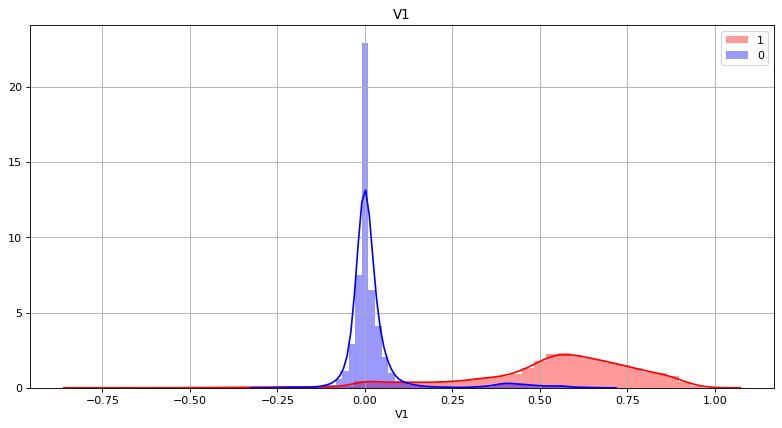

In [26]:
Visualization.show_hist(df_final, 0) # 由图可初步判断V1 的0.10~0.15区域可能为模糊区域，下面同理

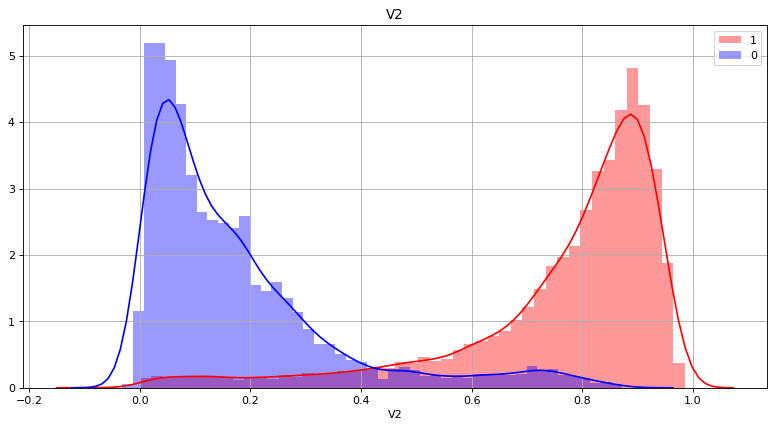

In [27]:
Visualization.show_hist(df_final, 1)

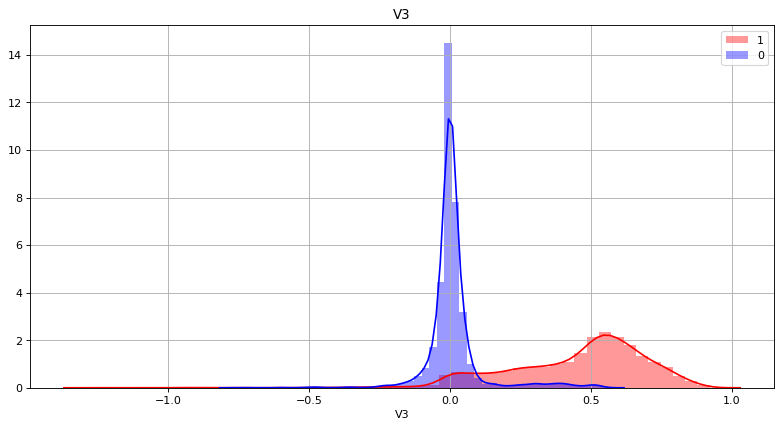

In [28]:
Visualization.show_hist(df_final,2)

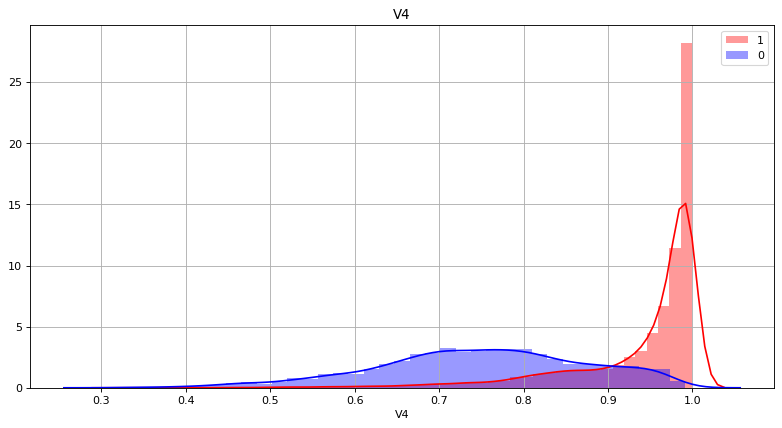

In [29]:
Visualization.show_hist(df_final, 3)

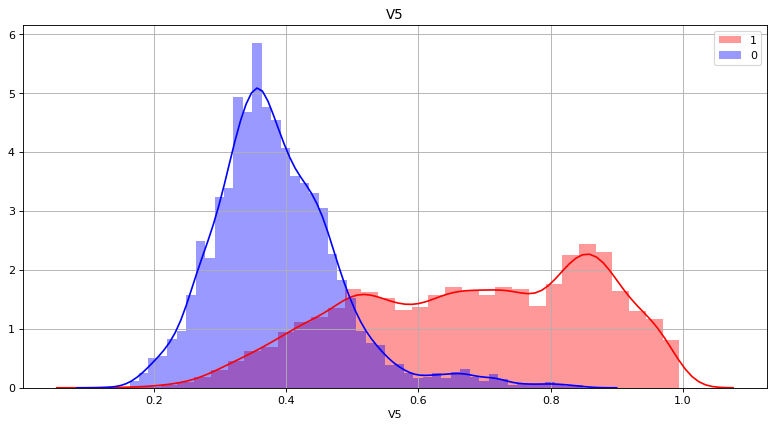

In [30]:
Visualization.show_hist(df_final, 4)

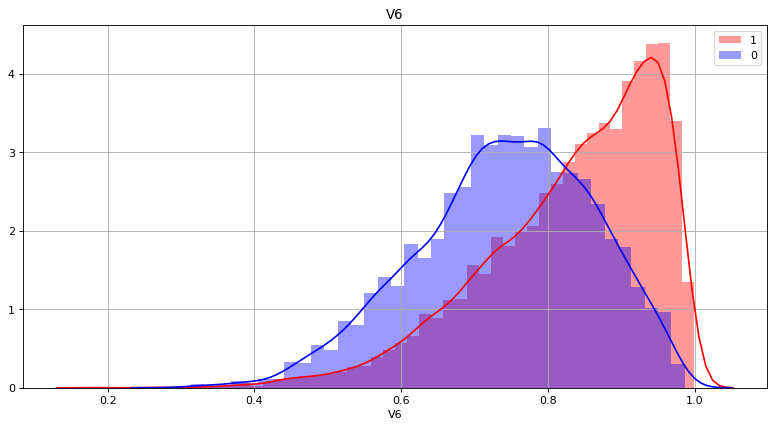

In [31]:
Visualization.show_hist(df_final, 5)

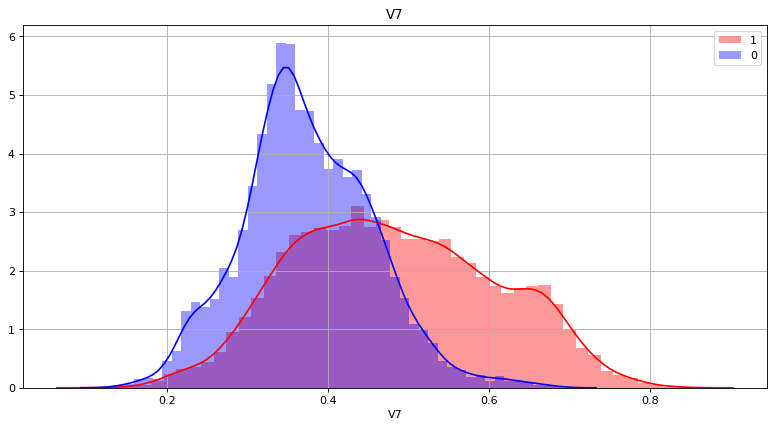

In [32]:
Visualization.show_hist(df_final, 6)

#### 连续值离散化，计算不同标签（0，1）的数据密度比值

In [33]:
bins_k = 59 # 将原始特征数据从最大值到最小值划分为59个区间，并用从0~58从小到大的整数去代表每一个区间

In [34]:
df_disper = pd.DataFrame()
df_retbins = pd.DataFrame()

In [35]:
# 离散化
for i in range(df_final.shape[1]-1):
    df_disper[list(df_final.columns)[i]+'_disper'] = pd.cut(df_final.iloc[:, i], bins_k, labels=range(bins_k), retbins=True)[0]
    df_retbins[list(df_final.columns)[i]+'_bins'] = pd.cut(df_final.iloc[:, i], bins_k, labels=range(bins_k), retbins=True)[1]

In [36]:
# 离散化后的数据
df_disper.head()

,V1_disper,V2_disper,V3_disper,V4_disper,V5_disper,V6_disper,V7_disper
0,44,54,48,58,48,51,41
1,40,46,43,49,27,53,40
2,55,57,53,58,49,39,25
3,26,9,34,40,19,45,23
4,25,6,33,26,18,37,22


In [37]:
# 原始数据划分的区间各个端点
df_retbins.head()

,V1_bins,V2_bins,V3_bins,V4_bins,V5_bins,V6_bins,V7_bins
0,-0.754441,-0.063735,-1.264126,0.320161,0.133583,0.182527,0.117578
1,-0.723609,-0.044929,-1.224945,0.332348,0.149017,0.197176,0.130674
2,-0.694495,-0.027171,-1.187947,0.343855,0.163592,0.211009,0.143040
3,-0.665381,-0.009412,-1.150949,0.355363,0.178166,0.224842,0.155405
4,-0.636267,0.008346,-1.113951,0.366870,0.192740,0.238675,0.167771


In [38]:
# 可视化离散化后的数据

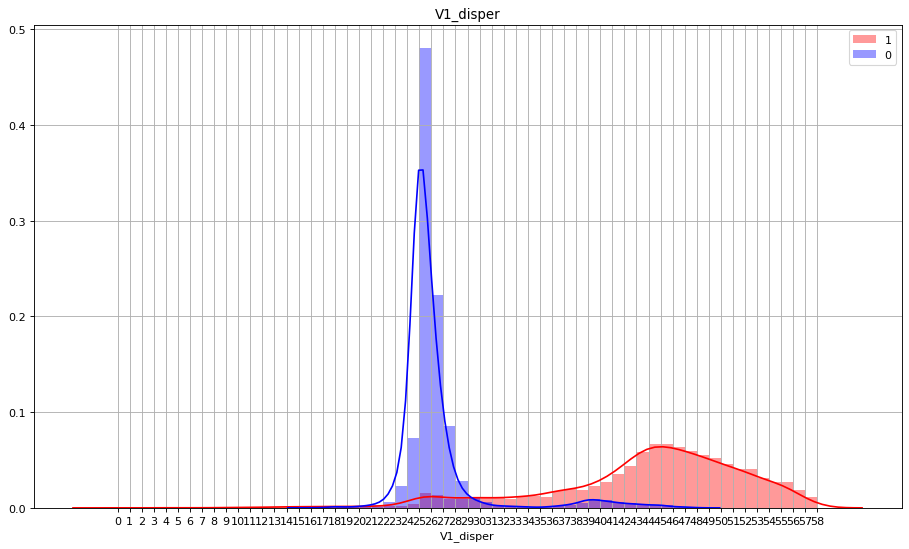

In [39]:
Visualization.show_disper_hist(df_disper, 0, bins_k) 

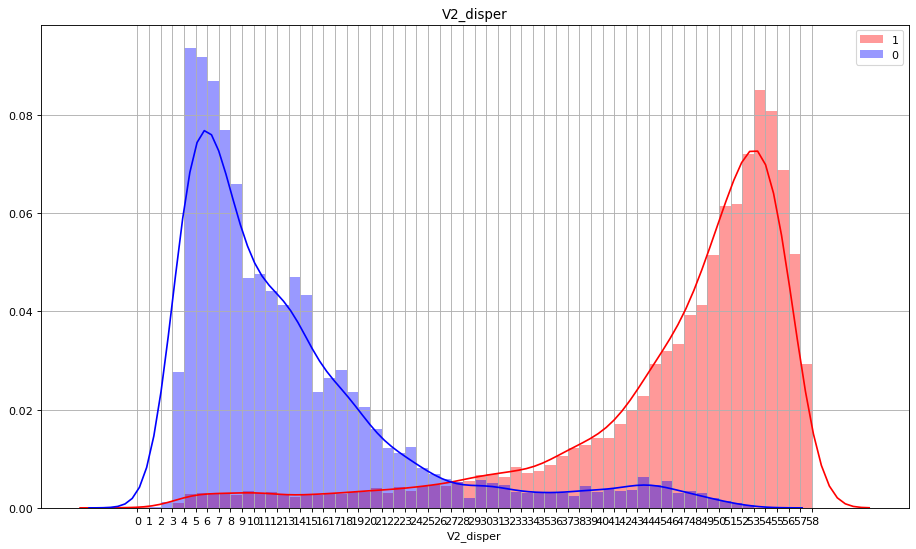

In [40]:
Visualization.show_disper_hist(df_disper, 1, bins_k) 

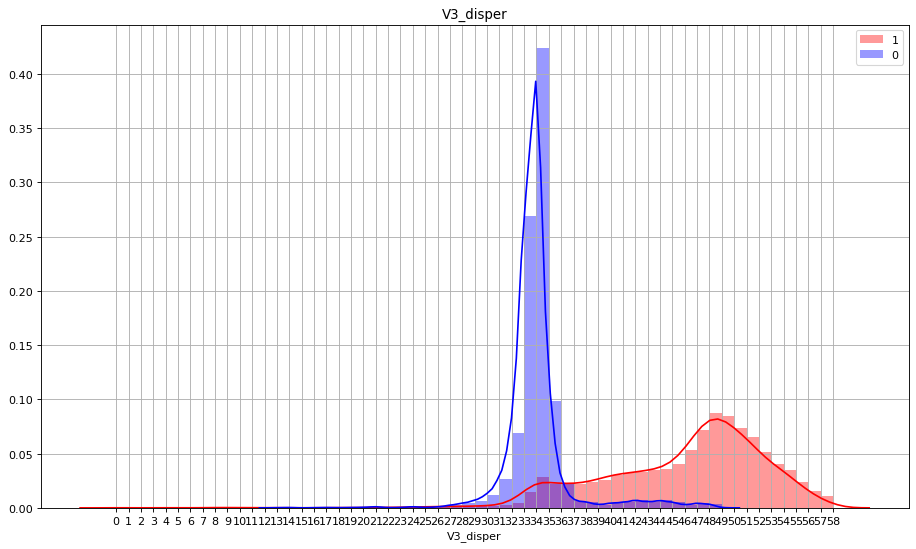

In [41]:
Visualization.show_disper_hist(df_disper, 2, bins_k) 

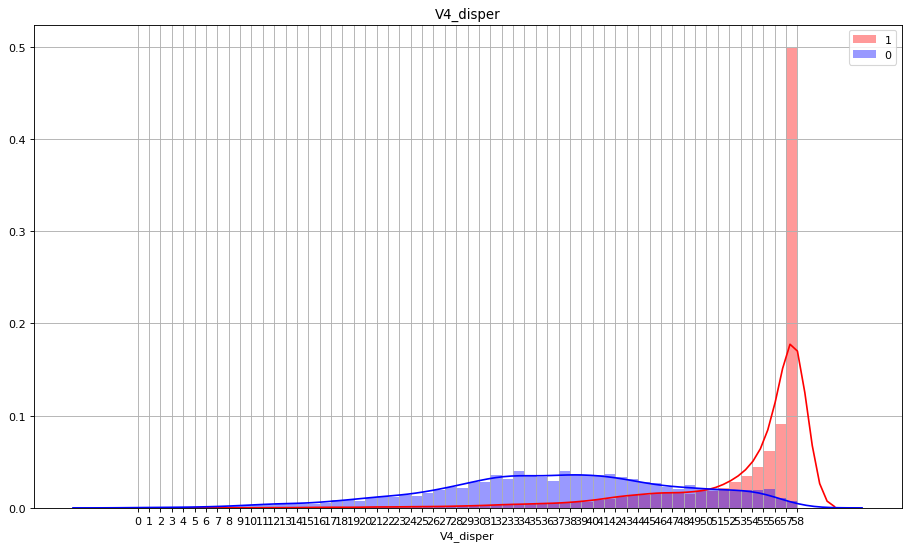

In [42]:
Visualization.show_disper_hist(df_disper, 3, bins_k) 

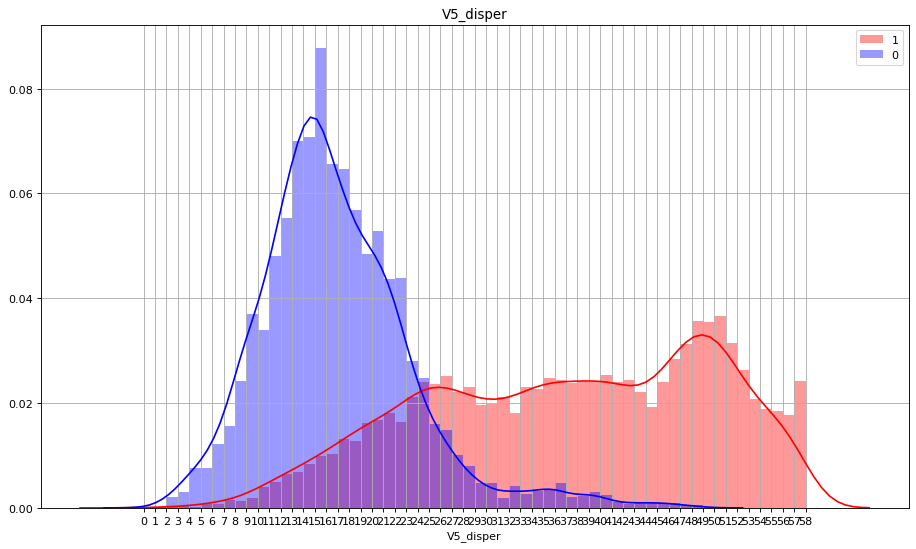

In [43]:
Visualization.show_disper_hist(df_disper, 4, bins_k) 

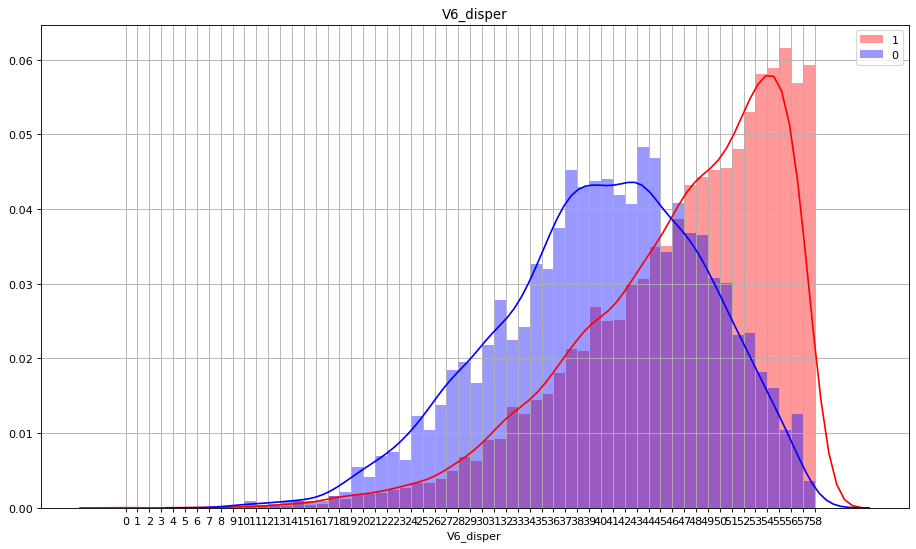

In [44]:
Visualization.show_disper_hist(df_disper, 5, bins_k) 

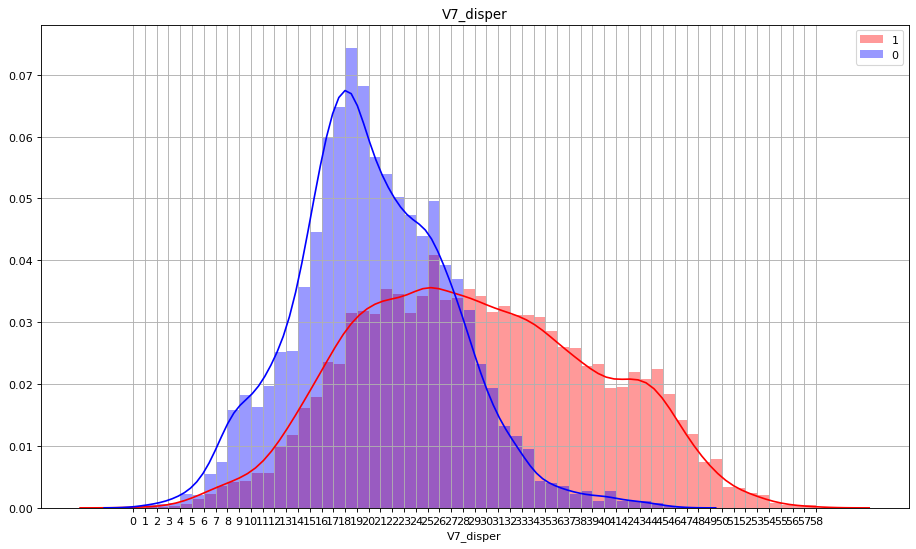

In [45]:
Visualization.show_disper_hist(df_disper, 6, bins_k) 

In [46]:
def get_fuzzy_list(bins_k, df_disper, df_retbins):
    """
    定义求模糊区域的函数,，计算同一特征的不同标签（0，1）对应的整数出现密度，然后用两者中的较小者和较大者做比（0<比值<1），
    如果比值超过某个规定的阈值(这里我们设置为0.5)则此整数对应的区域为模糊区域。
    """
    
    fuzzy_list = [[] for i in range(df_disper.shape[1])]
    disper_cols = list(df_disper.columns)
    for j in range(df_disper.shape[1]):
        for i in range(bins_k):
            total_0 = df_disper[disper_cols[j]][df_final['label'] == 0].count()
            total_1 = df_disper[disper_cols[j]][df_final['label'] == 1].count()
            element_0 = df_disper[disper_cols[j]][df_disper[disper_cols[j]] == i][df_final['label'] == 0].count()
            element_1 = df_disper[disper_cols[j]][df_disper[disper_cols[j]] == i][df_final['label'] == 1].count()
            max_v = max(element_0/total_0, element_1/total_1)
            min_v = min(element_0/total_0, element_1/total_1)
            if min_v/max_v >= 0.5:
                try:
    #                 fuzzy_list[j].append((df_retbins.iloc[i:i+1, j].values[0], df_retbins.iloc[i+1:i+2, j].values[0]))
                    fuzzy_list[j].append(df_retbins.iloc[i:i+1, j].values[0])
                    fuzzy_list[j].append(df_retbins.iloc[i+1:i+2, j].values[0])                   
                except Exception as err:
                    pass
    return fuzzy_list              

In [47]:
# 获得模糊区域数值列表
fuzzy_list = get_fuzzy_list(bins_k, df_disper, df_retbins)

In [48]:
# 对前一步得到的列表进行处理,得到整体的模糊区域区间端点
fuzzy_final = [[] for i in range(df_disper.shape[1])]
for i in range(7):
    for k, v in Counter(fuzzy_list[i]).items():
        if v==1:
            fuzzy_final[i].append(k)

In [49]:
"""以V1为例,可以从模糊区域列表得到V1的模糊区域为(-0.22867, -0.14132),以及(0.09158, 0.14981),其他特征同理"""
print(fuzzy_final[0])  # V1

[-0.22867149794008546, -0.14132952996740655, 0.09158238462640389, 0.14981036327485653]


In [84]:
print(fuzzy_final[1])  # V2

[0.36351178095537223, 0.43454494170039837, 0.45230323188665494, 0.5055781024454244]


In [85]:
print(fuzzy_final[2])  # V3

[-0.7809694597620098, -0.7439715217218499, -0.5959797695612099, -0.5219838934808899, -0.4109900793604099, -0.3369942032800899, -0.29999626523992984, -0.22600038915960985, 0.0699831151616701, 0.10698105320183005]


In [86]:
print(fuzzy_final[3])  # V4

[0.8271648589788514, 0.9422385943200764]


In [87]:
print(fuzzy_final[4]) # V5

[0.469652540492021, 0.5279498652102718]


In [88]:
print(fuzzy_final[5]) # V6

[0.3355045455184869, 0.36317026664594615, 0.37700312720967577, 0.39083598777340545, 0.404668848337135, 0.44616743002832393, 0.6259946173568091, 0.6536603384842683, 0.7228246413029165, 0.888818968067672]


In [89]:
print(fuzzy_final[6]) # V7

[0.18013724435652614, 0.19250313463049598, 0.3656255984660736, 0.5016503914797418]


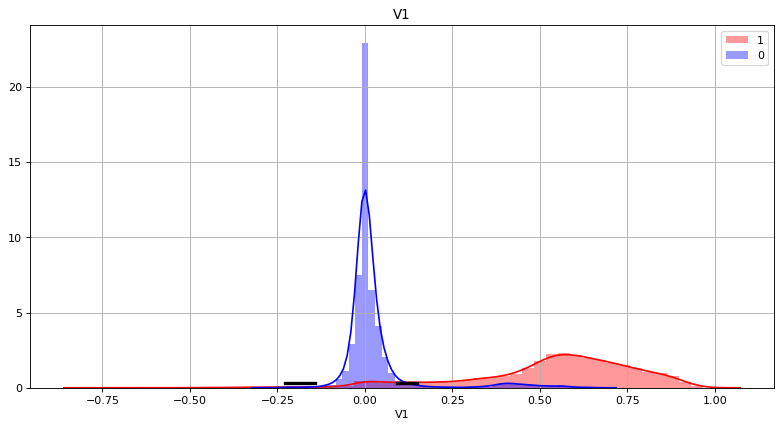

In [50]:
Visualization.show_fuzzy_hist(0, fuzzy_final, df_final)

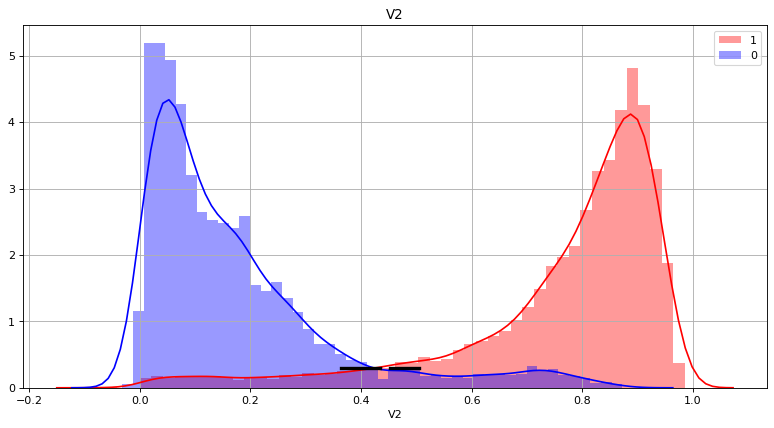

In [51]:
Visualization.show_fuzzy_hist(1, fuzzy_final, df_final)

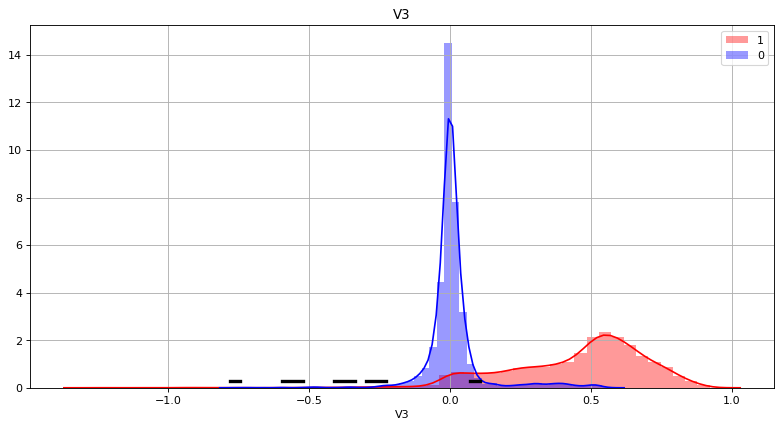

In [52]:
Visualization.show_fuzzy_hist(2, fuzzy_final, df_final)

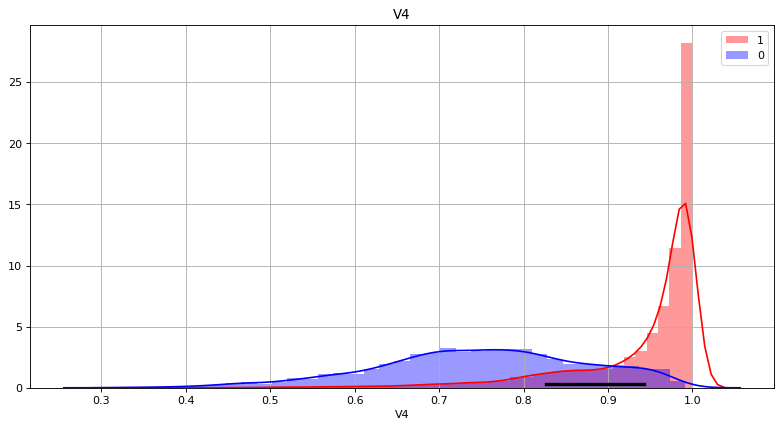

In [53]:
Visualization.show_fuzzy_hist(3, fuzzy_final, df_final)

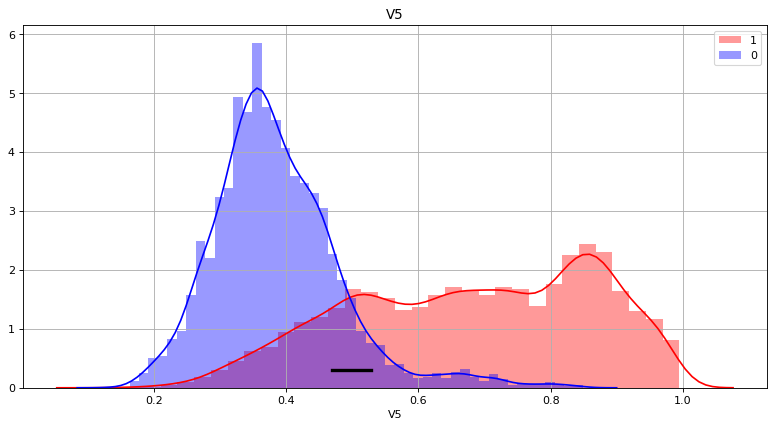

In [54]:
Visualization.show_fuzzy_hist(4, fuzzy_final, df_final)

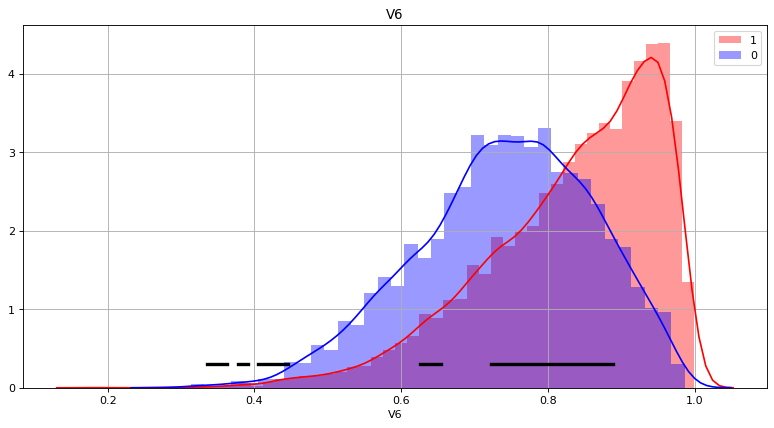

In [55]:
Visualization.show_fuzzy_hist(5, fuzzy_final, df_final)

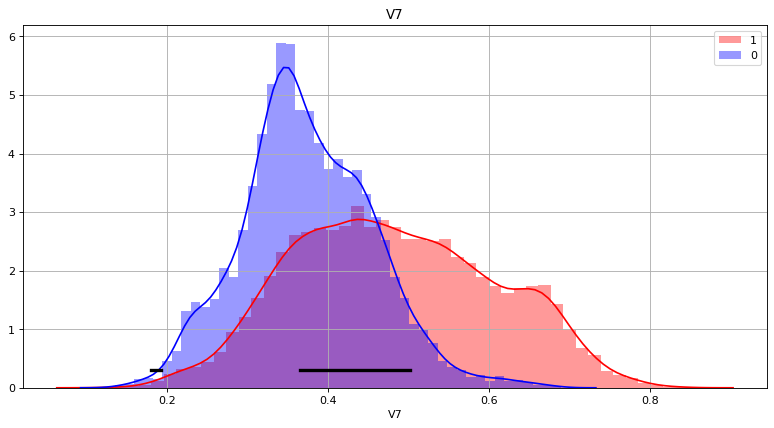

In [56]:
Visualization.show_fuzzy_hist(6, fuzzy_final, df_final)

## 题目三 训练模型-预测前10条测试数据
- 思路:
- - PCA降维: 由于特征矩阵过大，可能导致计算量大，训练时间长的问题，因此考虑是否需要降低特征矩阵维度
- 对比使用主成分分析pca降维后的数据训练模型,和使用原始数据训练模型的效果,决定是否采用pca降维
- 用不同分类器,进行模型训练,即模型的参数择优以及参数评估(检验模型的泛化能力)
- 用多个分类器对测试数据进行预测,对比结果,综合后得到测试集前10条数据得标签(是否含有特定成分(1为含有，0为不含))

### 数据预处理

#### PCA 降维

In [57]:
pca = PCA(5)
pca.fit(df_final.iloc[:, :-1])
X_new = pca.transform(df_final.iloc[:, :-1])
# df_test_dec = pca.transform(df_test)
df_new = pd.concat([pd.DataFrame(X_new), df_final.iloc[:, -1:]], axis=1)
df_new.head()
# pca.show_ew()

,0,1,2,3,4,label
0,-0.498847,0.170962,0.027148,0.101273,0.008086,1
1,-0.157257,0.117360,0.133602,-0.038752,-0.018633,1
2,-0.765452,-0.169746,-0.064361,0.019545,0.049162,1
3,0.695995,0.089912,-0.101523,-0.052401,-0.014425,0
4,0.786307,-0.017279,-0.137075,0.025484,0.064990,0


In [58]:
pca.explained_variance_ratio_.sum()

0.9824642197624747

In [59]:
pca.score_samples(X_test)

array([ 7.07594119,  3.93278898,  6.57300546, ...,  8.04909009,
        6.99765122, -3.40326033])

#### 数据集划分

##### 用PCA降维后的数据

In [60]:
X_pca, y_pca = df_new.iloc[:, :-1], df_new.iloc[:, -1:]  # 除标签列之外的特征

# 数据集划分
train_x_pca, test_x_pca, train_y_pca, test_y_pca = train_test_split(X_pca, y_pca, test_size=0.4, random_state=0, stratify=y_pca)
print('总特征集X大小：{}, 总标签y大小：{}'.format(X_pca.shape, y_pca.shape))
print('train_x：{}, train_y:{}, test_x:{}, test_y: {} '.format(train_x_pca.shape, train_y_pca.shape, test_x_pca.shape,
                                                              test_y_pca.shape))

总特征集X大小：(20000, 5), 总标签y大小：(20000, 1)
train_x：(12000, 5), train_y:(12000, 1), test_x:(8000, 5), test_y: (8000, 1) 


###### 原始数据

In [61]:
X, y = df_final.iloc[:, :-1], df_final.iloc[:, -1:]  # 除标签列之外的特征
# 数据集划分
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.4, random_state=0, stratify=y)
# 标准化 / 归一化
# mms = MinMaxScaler()
# mms.fit(X)
# train_x_std = mms.transform(train_x)
# test_x_std = mms.transform(test_x)
# X_std = mms.transform(X)
# df_test_std = mms.transform(df_test)
sc = StandardScaler()
sc.fit(X)
train_x_std = sc.transform(train_x)
test_x_std = sc.transform(test_x)
df_test_std = sc.transform(df_test)
X_std = sc.transform(X)

print('总特征集X大小：{}, 总标签y大小：{}'.format(X.shape, y.shape))
print('train_x：{}, train_y:{}, test_x:{}, test_y: {} '.format(train_x.shape, train_y.shape, test_x.shape,
                                                              test_y.shape))
print('总测试集：', df_test.shape)

总特征集X大小：(20000, 7), 总标签y大小：(20000, 1)
train_x：(12000, 7), train_y:(12000, 1), test_x:(8000, 7), test_y: (8000, 1) 
总测试集： (5000, 7)


###### 对比降维数据和不降维数据的分类效果
- 使用决策树方法进行对比

In [62]:
# 降维数据

In [63]:
show_model_status(model_list[0])
# 参数寻优
param_grid_tree = [{'random_state':[0],'criterion':['gini','entropy'], 'max_depth':list(range(2,10,2)),'max_leaf_nodes':list(range(8,40,5))}]
paramselect = ParamSelect(train_x_pca, train_y_pca, DecisionTreeClassifier())
best_param_tree = paramselect.get_best_param(param_grid_tree)

----------------------------------------------------------------------------------------------------
DecisionTree 模型训练及评估：
参数寻优：
Best score: 0.933960 using {'criterion': 'gini', 'max_depth': 6, 'max_leaf_nodes': 33, 'random_state': 0}


In [64]:
# 用最优参数训练模型
clf_pca = DecisionTreeClassifier(**best_param_tree)
clf_pca.fit(train_x_pca, train_y_pca)
clf_pca.predict(test_x_pca)
clf_pca.score(test_x_pca, test_y_pca)

0.936375

In [65]:
# 原始数据

In [66]:
show_model_status(model_list[0])
# 参数寻优
param_grid_tree = [{'random_state':[0],'criterion':['gini','entropy'], 'max_depth':list(range(2,10,2)),'max_leaf_nodes':list(range(8,40,5))}]
paramselect = ParamSelect(train_x, train_y, DecisionTreeClassifier())
best_param_tree = paramselect.get_best_param(param_grid_tree)

----------------------------------------------------------------------------------------------------
DecisionTree 模型训练及评估：
参数寻优：
Best score: 0.937591 using {'criterion': 'gini', 'max_depth': 8, 'max_leaf_nodes': 18, 'random_state': 0}


In [67]:
# 用最优参数训练模型
clf_org = DecisionTreeClassifier(**best_param_tree)
clf_org.fit(train_x, train_y)
clf_org.predict(test_x)
clf_org.score(test_x, test_y)

0.9415

**可以明显看出，使用原始数据比使用PCA降维后的数据效果好，所以我们使用原始数据训练模型，并对测试数据作出预测**

### 模型训练

#### DecisionTree

In [68]:
show_model_status(model_list[0])
# 参数寻优
param_grid_tree = [{'random_state':[0],'criterion':['gini','entropy'], 'max_depth':list(range(8,14,2)),'max_leaf_nodes':list(range(8,40,5))}]
paramselect = ParamSelect(train_x, train_y, DecisionTreeClassifier())
best_param_tree = paramselect.get_best_param(param_grid_tree)

----------------------------------------------------------------------------------------------------
DecisionTree 模型训练及评估：
参数寻优：
Best score: 0.937672 using {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 18, 'random_state': 0}


交叉验证：
10fold cross validation f1_weighted score in final model: 0.939 +/- 0.008
cv-f1-score: 0.9386083464457717
test-f1-score: 0.9416834776815456
Detailed classification report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      2442
           1       0.96      0.95      0.96      5558

    accuracy                           0.94      8000
   macro avg       0.93      0.93      0.93      8000
weighted avg       0.94      0.94      0.94      8000

confusion matrix:
 [[2236  206]
 [ 262 5296]]


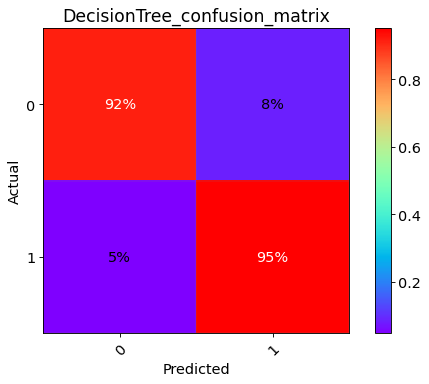

Learning curve:


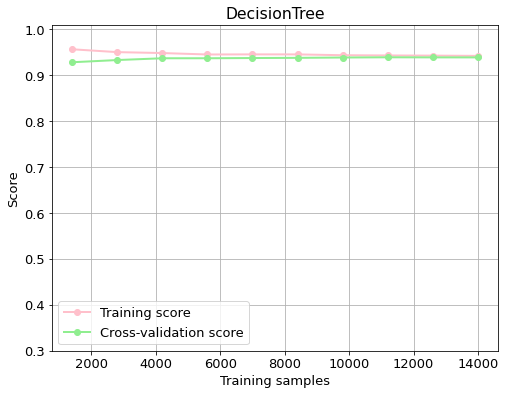

In [69]:
# 用最优参数训练模型
clf_dt = DecisionTreeClassifier(**best_param_tree)
df_score.loc[model_list[0], 'cv_f1_score'], df_score.loc[model_list[0], 'accuracy']= ModelEvaluation.my_pipeline(train_x, train_y, test_x, test_y, X, y, clf_dt, model_list[0]), clf_dt.score(test_x, test_y)

<Figure size 432x288 with 0 Axes>

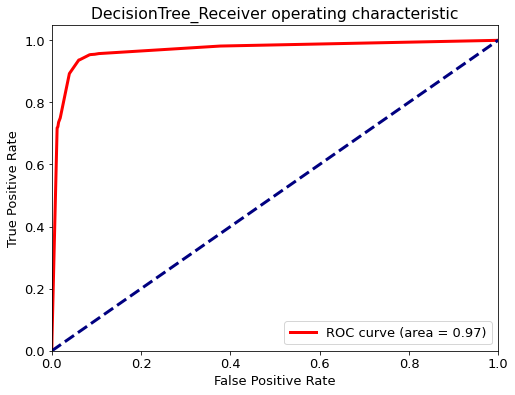

In [70]:
# roc 曲线
ModelEvaluation.show_roc_curve(test_y, clf_dt.predict_proba(test_x)[:, 1], model_list[0])

In [71]:
df_pred =  pd.concat([df_pred,ModelEvaluation.get_test_result(clf_dt, df_test, model_list[0]).head(10)], axis = 1)

#### KNN

In [72]:
show_model_status(model_list[2])
param_grid_knn = [{'n_neighbors':list(range(8,12))}]
# 选择最优参数
paramselect = ParamSelect(train_x_std, train_y, KNeighborsClassifier())
best_param_knn = paramselect.get_best_param(param_grid_knn)

----------------------------------------------------------------------------------------------------
Svm 模型训练及评估：
参数寻优：
Best score: 0.934385 using {'n_neighbors': 9}


交叉验证：
10fold cross validation f1_weighted score in final model: 0.941 +/- 0.009
cv-f1-score: 0.9405885064108771
test-f1-score: 0.9406132510820577
Detailed classification report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.91      2442
           1       0.97      0.94      0.96      5558

    accuracy                           0.94      8000
   macro avg       0.92      0.94      0.93      8000
weighted avg       0.94      0.94      0.94      8000

confusion matrix:
 [[2299  143]
 [ 337 5221]]


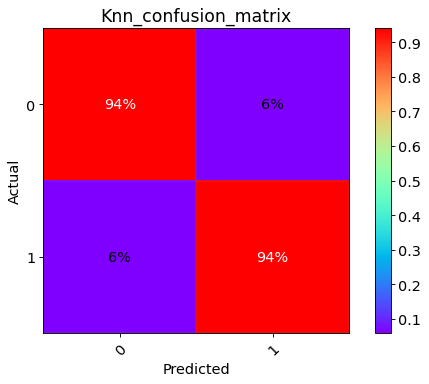

Learning curve:


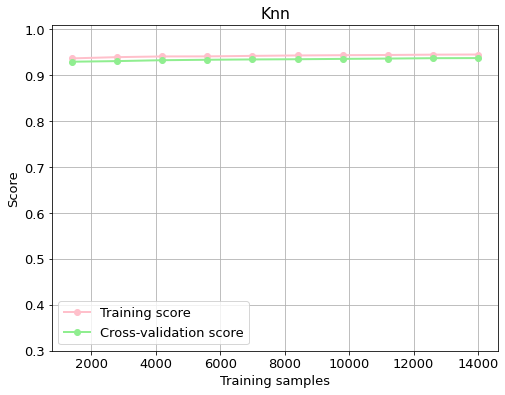

In [83]:
# 用最优参数训练模型
clf_knn = KNeighborsClassifier(**best_param_knn)
df_score.loc[model_list[1], 'cv_f1_score'], df_score.loc[model_list[1], 'accuracy']= ModelEvaluation.my_pipeline(train_x_std, train_y, test_x_std, test_y, X_std, y, clf_knn, model_list[1]), clf_knn.score(test_x_std, test_y)

<Figure size 432x288 with 0 Axes>

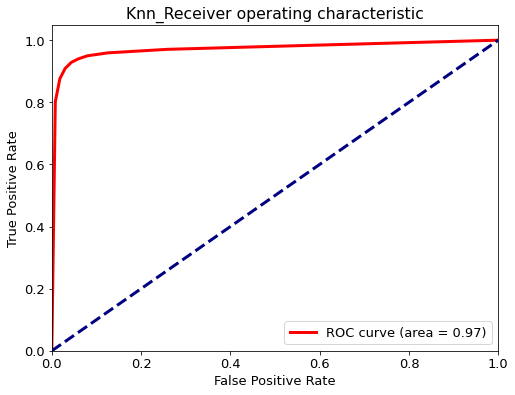

In [74]:
# roc曲线
ModelEvaluation.show_roc_curve(test_y, clf_knn.predict_proba(test_x_std)[:, 1], model_list[1])

In [75]:
df_pred =  pd.concat([df_pred,ModelEvaluation.get_test_result(clf_knn, df_test_std, model_list[1]).head(10)], axis = 1)

#### SVM

In [76]:
show_model_status(model_list[1])
# 给定超参数范围
# {'C': param_range_svm, 'kernel': ['rbf'], 'gamma':param_range_svm}
# {'C': param_range_svm, 'kernel': ['linear']}
param_range_svm = [ 0.1, 1]
param_grid_svm = [{'C': param_range_svm, 'kernel': ['rbf'], 'gamma':param_range_svm}]
# 选择最优参数
paramselect = ParamSelect(train_x_std, train_y, svm.SVC())
best_param_svm = paramselect.get_best_param(param_grid_svm)

----------------------------------------------------------------------------------------------------
Knn 模型训练及评估：
参数寻优：
Best score: 0.939347 using {'C': 1, 'gamma': 1, 'kernel': 'rbf'}


交叉验证：
10fold cross validation f1_weighted score in final model: 0.943 +/- 0.008
cv-f1-score: 0.9434877621195898
test-f1-score: 0.944123325431349
Detailed classification report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      2442
           1       0.97      0.95      0.96      5558

    accuracy                           0.94      8000
   macro avg       0.93      0.94      0.93      8000
weighted avg       0.94      0.94      0.94      8000

confusion matrix:
 [[2278  164]
 [ 286 5272]]


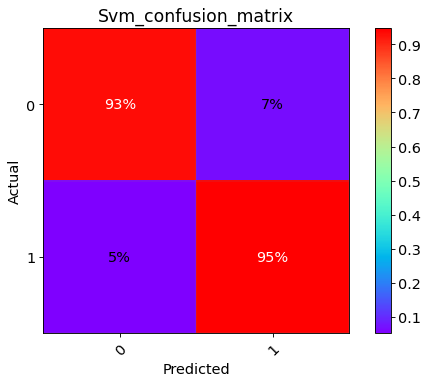

Learning curve:


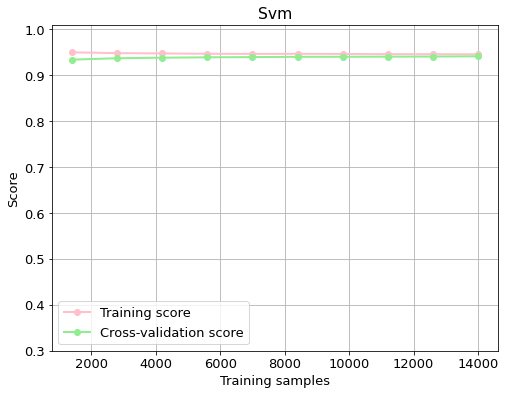

In [77]:
# 用最优参数训练模型
clf_svm = svm.SVC(**best_param_svm, probability=True)
df_score.loc[model_list[2], 'cv_f1_score'], df_score.loc[model_list[2], 'accuracy']= ModelEvaluation.my_pipeline(train_x_std, train_y, test_x_std, test_y, X_std, y, clf_svm, model_list[2]), clf_svm.score(test_x_std, test_y)

<Figure size 432x288 with 0 Axes>

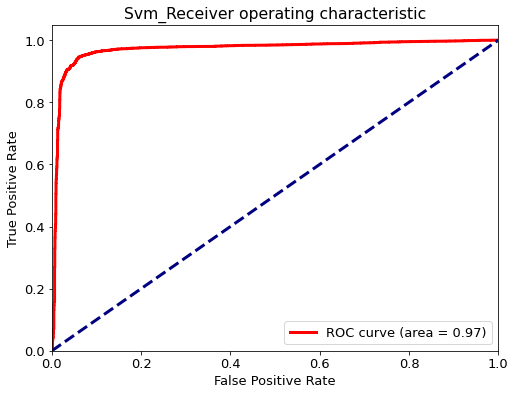

In [78]:
# roc 曲线
ModelEvaluation.show_roc_curve(test_y, clf_svm.predict_proba(test_x_std)[:, 1], model_list[2])

In [79]:
df_pred =  pd.concat([df_pred,ModelEvaluation.get_test_result(clf_svm, df_test_std, model_list[2]).head(10)], axis = 1)

### 最终结果

In [94]:
df_pred.T  # 结论,10条数据全为1  即都含有特定成分

,0,1,2,3,4,5,6,7,8,9
DecisionTree_pred_y,1,1,1,1,1,1,1,1,1,1
Knn_pred_y,1,1,1,1,1,1,1,1,1,1
Svm_pred_y,1,1,1,1,1,1,1,1,1,1


In [82]:
df_score.sort_values(by='cv_f1_score', ascending = False) # 模型得分

,cv_f1_score,accuracy
Svm,0.943488,0.94375
Knn,0.94187,0.94
DecisionTree,0.938608,0.9415
